In [13]:
import json
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [14]:
PROJECT_ROOT = Path.cwd().parent  # 'BoneTumor/' if you're running from notebooks/
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "BTXRD"

# Paths to subfolders
ANNOTATIONS_DIR = DATA_DIR / "Annotations"
IMAGES_DIR = DATA_DIR / "images"
METADATA_FILE = DATA_DIR / "dataset.xlsx"  # e.g., "dataset.xlsx"
OUTPUT_CSV = PROJECT_ROOT / "data" / "interim" / "merged_annotations.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("ANNOTATIONS_DIR:", ANNOTATIONS_DIR)
print("IMAGES_DIR:", IMAGES_DIR)
print("METADATA_FILE:", METADATA_FILE)
print("OUTPUT_CSV:", OUTPUT_CSV)

PROJECT_ROOT: /home/dzakirm/Research/BoneTumor
DATA_DIR: /home/dzakirm/Research/BoneTumor/data/raw/BTXRD
ANNOTATIONS_DIR: /home/dzakirm/Research/BoneTumor/data/raw/BTXRD/Annotations
IMAGES_DIR: /home/dzakirm/Research/BoneTumor/data/raw/BTXRD/images
METADATA_FILE: /home/dzakirm/Research/BoneTumor/data/raw/BTXRD/dataset.xlsx
OUTPUT_CSV: /home/dzakirm/Research/BoneTumor/data/interim/merged_annotations.csv


In [15]:
df_meta = pd.read_excel(METADATA_FILE)

# We assume the metadata Excel file has a column "image_id"
# with values like "IMG000001.jpeg", etc.
# We strip off the extension to get "IMG000001".
if "image_id" in df_meta.columns:
    df_meta["base_filename"] = df_meta["image_id"].apply(lambda x: Path(x).stem)
else:
    raise ValueError("The metadata must contain an 'image_id' column.")

print("\nMetadata sample:")
display(df_meta.head())



Metadata sample:


,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,...,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique,base_filename
0,IMG000001.jpeg,1,48,F,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,IMG000001
1,IMG000002.jpeg,1,12,M,0,0,0,0,0,1,...,0,1,0,0,1,0,1,0,0,IMG000002
2,IMG000003.jpeg,1,12,M,0,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,IMG000003
3,IMG000004.jpeg,1,52,M,0,0,0,0,1,0,...,0,1,0,0,1,0,1,0,0,IMG000004
4,IMG000005.jpeg,1,52,M,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,IMG000005


In [16]:
all_shape_records = []

annotation_files = list(ANNOTATIONS_DIR.glob("*.json"))
print(f"\nFound {len(annotation_files)} annotation JSON files in {ANNOTATIONS_DIR}.")

for ann_file in annotation_files:
    with ann_file.open("r") as f:
        ann_data = json.load(f)

    # Use the file stem as base_filename (e.g., "IMG000001")
    base_filename = ann_file.stem
    image_width = ann_data.get("imageWidth", None)
    image_height = ann_data.get("imageHeight", None)

    shapes = ann_data.get("shapes", [])
    for shape in shapes:
        label = shape.get("label", "")
        shape_type = shape.get("shape_type", "")
        points = shape.get("points", [])

        # For rectangles, we assume the first two points represent opposite corners.
        if shape_type == "rectangle" and len(points) >= 2:
            bbox = [
                int(round(points[0][0])), int(round(points[0][1])),
                int(round(points[1][0])), int(round(points[1][1]))
            ]
            segmentation = ""  # no separate segmentation for rectangular boxes
        # For polygons (segmentation), we join the coordinates into a string.
        elif shape_type == "polygon" and points:
            segmentation = ";".join([f"{int(round(pt[0]))},{int(round(pt[1]))}" for pt in points])
            bbox = ""  # bbox can be left blank or computed from polygon points if needed
        else:
            bbox = ""
            segmentation = ""

        record = {
            "base_filename": base_filename,
            "label": label,          # local label, e.g., could be 'other mt' etc.
            "shape_type": shape_type,
            "bbox": bbox,
            "segmentation": segmentation,
            "image_width": image_width,
            "image_height": image_height
        }
        all_shape_records.append(record)

df_shapes = pd.DataFrame(all_shape_records)
print("\nLocal annotation shapes sample:")
display(df_shapes.head())


Found 1867 annotation JSON files in /home/dzakirm/Research/BoneTumor/data/raw/BTXRD/Annotations.

Local annotation shapes sample:


,base_filename,label,shape_type,bbox,segmentation,image_width,image_height
0,IMG000001,other mt,rectangle,"[1965, 620, 2930, 1252]",,3213,2397
1,IMG000001,other mt,polygon,,"2028,1220;2014,1184;2021,1122;2089,1027;2139,9...",3213,2397
2,IMG000002,osteosarcoma,rectangle,"[886, 343, 1115, 1189]",,1640,3032
3,IMG000002,osteosarcoma,polygon,,"896,614;896,588;903,551;916,497;919,443;922,38...",1640,3032
4,IMG000003,osteosarcoma,rectangle,"[781, 559, 1095, 1059]",,2276,3032


In [17]:
df_merged = pd.merge(df_shapes, df_meta, on="base_filename", how="left")

# Save the merged data to CSV for subsequent analysis or model training.
OUTPUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df_merged.to_csv(OUTPUT_CSV, index=False)
print(f"\nMerged annotations (with classification & segmentation) exported to: {OUTPUT_CSV}")



Merged annotations (with classification & segmentation) exported to: /home/dzakirm/Research/BoneTumor/data/interim/merged_annotations.csv


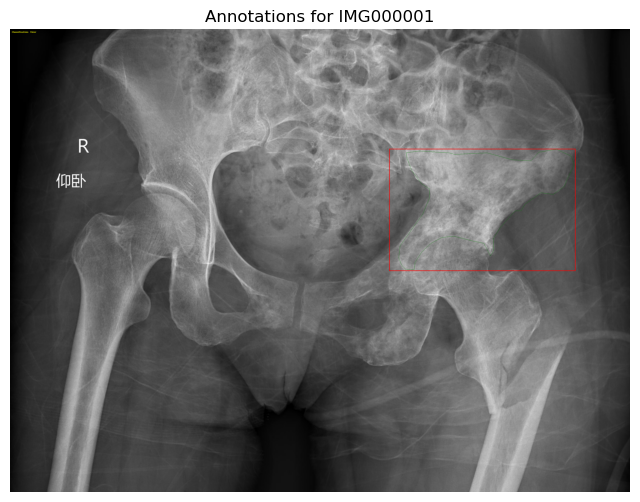

In [26]:
if annotation_files:
    example_file = annotation_files[0]
    with example_file.open("r") as f:
        example_ann = json.load(f)

    example_base = example_file.stem
    example_img_path = IMAGES_DIR / f"{example_base}.jpeg"

    if example_img_path.exists():
        img = Image.open(example_img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        for shape in example_ann.get("shapes", []):
            # For rectangle annotations: draw bounding box.
            if shape.get("shape_type") == "rectangle" and len(shape["points"]) >= 2:
                pt1 = tuple(int(round(coord)) for coord in shape["points"][0])
                pt2 = tuple(int(round(coord)) for coord in shape["points"][1])
                bbox = pt1 + pt2
                draw.rectangle(bbox, outline="red", width=3)
            # For polygon annotations (segmentation): draw the outline.
            elif shape.get("shape_type") == "polygon" and shape.get("points"):
                polygon_points = [ (int(round(pt[0])), int(round(pt[1]))) for pt in shape["points"] ]
                draw.polygon(polygon_points, outline="green")

        # Retrieve the global classification label from metadata.
        # Adjust the column name as needed—in this example, we assume a column named "classification" exists.
        meta_row = df_meta[df_meta["base_filename"] == example_base]
        if not meta_row.empty:
            # Try using a 'classification' column; if not, build one from available tumor flags.
            if "classification" in meta_row.columns:
                classification_label = meta_row["classification"].iloc[0]
            elif "tumor" in meta_row.columns and "benign" in meta_row.columns and "malignant" in meta_row.columns:
                # For example, if tumor flag is 1 then image is tumorous (you can refine this logic as needed)
                classification_label = "Tumor" if meta_row["tumor"].iloc[0] == 1 else "Normal"
            else:
                classification_label = "N/A"
            # Draw the classification label on the image.
            draw.text((10, 10), f"Classification: {classification_label}", fill="yellow")

        plt.figure(figsize=(8,8))df_meta[["base_filename", "classification"]].head()
        plt.imshow(img)
        plt.title(f"Annotations for {example_base}")
        plt.axis("off")
        plt.show()
    else:
        print(f"Image file not found: {example_img_path}")

In [24]:
df_shapes[["base_filename", "label"]].head()

,base_filename,label
0,IMG000001,other mt
1,IMG000001,other mt
2,IMG000002,osteosarcoma
3,IMG000002,osteosarcoma
4,IMG000003,osteosarcoma


In [23]:
df_shapes

,base_filename,label,shape_type,bbox,segmentation,image_width,image_height
0,IMG000001,other mt,rectangle,"[1965, 620, 2930, 1252]",,3213,2397
1,IMG000001,other mt,polygon,,"2028,1220;2014,1184;2021,1122;2089,1027;2139,9...",3213,2397
2,IMG000002,osteosarcoma,rectangle,"[886, 343, 1115, 1189]",,1640,3032
3,IMG000002,osteosarcoma,polygon,,"896,614;896,588;903,551;916,497;919,443;922,38...",1640,3032
4,IMG000003,osteosarcoma,rectangle,"[781, 559, 1095, 1059]",,2276,3032
...,...,...,...,...,...,...,...
4637,IMG001865,other mt,polygon,,"364,192;312,186;278,184;248,185;217,193;180,24...",550,1029
4638,IMG001866,other mt,rectangle,"[201, 199, 462, 455]",,575,1027
4639,IMG001866,other mt,polygon,,"288,201;264,217;232,239;225,255;217,281;210,32...",575,1027
4640,IMG001867,osteosarcoma,rectangle,"[122, 17, 371, 330]",,520,770


In [1]:
import json
from pathlib import Path

input_dir = Path("../data/raw/BTXRD/Annotations")     # folder containing *.json
output_dir = Path("../data/interim/labels")    # output YOLO txt labels
output_dir.mkdir(parents=True, exist_ok=True)


class_list = []

def class_to_id(label: str) -> int:
    """Get class ID and dynamically add if new."""
    if label not in class_list:
        class_list.append(label)
    return class_list.index(label)

def normalize_bbox(x1, y1, x2, y2, w, h):
    xc = (x1 + x2) / 2 / w
    yc = (y1 + y2) / 2 / h
    bw = abs(x2 - x1) / w
    bh = abs(y2 - y1) / h
    return [xc, yc, bw, bh]

def normalize_polygon(points, w, h):
    return [f"{x/w:.6f}" if i % 2 == 0 else f"{y/h:.6f}"
            for i, (x, y) in enumerate(points)]

def process_file(json_path: Path):
    with json_path.open() as f:
        data = json.load(f)

    w, h = data["imageWidth"], data["imageHeight"]
    output_file = output_dir / f"{json_path.stem}.txt"
    lines = []

    for shape in data["shapes"]:
        label = shape["label"]
        shape_type = shape["shape_type"]
        points = shape["points"]

        class_id = class_to_id(label)

        if shape_type == "rectangle":
            x1, y1 = points[0]
            x2, y2 = points[1]
            box = normalize_bbox(x1, y1, x2, y2, w, h)
            lines.append(f"{class_id} {' '.join(f'{v:.6f}' for v in box)}")

        elif shape_type == "polygon":
            flat_points = normalize_polygon(points, w, h)
            lines.append(f"{class_id} {' '.join(flat_points)}")

        # Optional: you can add `else:` to log or skip unsupported types

    output_file.write_text("\n".join(lines))

# === PROCESS ALL FILES ===
json_files = list(input_dir.glob("*.json"))

for json_path in json_files:
    process_file(json_path)

# === SAVE CLASSES ===
(output_dir / "classes.txt").write_text("\n".join(class_list))

print(f"✅ Converted {len(json_files)} JSON files")
print(f"📚 Classes saved to: {output_dir/'classes.txt'}")


✅ Converted 1867 JSON files
📚 Classes saved to: ../interim/labels/classes.txt


In [3]:
import json
import numpy as np
import csv
from pathlib import Path
from PIL import Image, ImageDraw

# Input and output paths
json_dir = Path("../data/raw/BTXRD/Annotations")     # folder containing *.json
parsed_dir = Path("parsed")
detect_dir = parsed_dir / "detect"
segment_dir = parsed_dir / "segment"
parsed_dir.mkdir(parents=True, exist_ok=True)
detect_dir.mkdir(parents=True, exist_ok=True)
segment_dir.mkdir(parents=True, exist_ok=True)

# Image-level classification output
classification_csv = parsed_dir / "classification.csv"
classification_records = []

# Optional: set class mapping
class_map = {"other mt": 0}  # Extend as needed

def convert_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    """YOLO bbox format: x_center, y_center, width, height (normalized)"""
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h
    return x_center, y_center, w, h

# Iterate all JSONs
for json_file in json_dir.glob("*.json"):
    with open(json_file) as f:
        data = json.load(f)

    image_name = Path(data["imagePath"]).stem
    img_w, img_h = data["imageWidth"], data["imageHeight"]

    # For detection
    yolo_lines = []

    # For segmentation (YOLO polygon-style)
    segment_lines = []

    # For classification (based on all unique labels in an image)
    image_labels = set()

    for shape in data["shapes"]:
        label = shape["label"]
        class_id = class_map.get(label, 0)  # fallback to 0
        image_labels.add(label)

        if shape["shape_type"] == "rectangle":
            (x1, y1), (x2, y2) = shape["points"]
            bbox = convert_bbox(x1, y1, x2, y2, img_w, img_h)
            yolo_lines.append(f"{class_id} " + " ".join(f"{v:.6f}" for v in bbox))

        elif shape["shape_type"] == "polygon":
            flat_coords = []
            for x, y in shape["points"]:
                flat_coords.append(x / img_w)
                flat_coords.append(y / img_h)
            segment_lines.append(f"{class_id} " + " ".join(f"{v:.6f}" for v in flat_coords))

    # Save YOLO detection
    if yolo_lines:
        with open(detect_dir / f"{image_name}.txt", "w") as f:
            f.write("\n".join(yolo_lines))

    # Save YOLO segmentation-style polygon
    if segment_lines:
        with open(segment_dir / f"{image_name}.txt", "w") as f:
            f.write("\n".join(segment_lines))

    # Save classification entry (multi-label style)
    classification_records.append({
        "image": image_name,
        "labels": ",".join(sorted(image_labels))
    })

# Save image classification CSV
with open(classification_csv, "w", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["image", "labels"])
    writer.writeheader()
    for row in classification_records:
        writer.writerow(row)

print("[✔] All tasks completed: detection, segmentation (YOLO-style), classification.")


[✔] All tasks completed: detection, segmentation (YOLO-style), classification.
